# **Early detection of postnatal depression in women**

# 4. Loading Python libraries

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install dython

In [4]:
!pip install colorama tensorflow

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.ticker import StrMethodFormatter
from colorama import Fore, Style
from dython.nominal import associations


from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV

from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.backend import clear_session
from tensorflow.config import list_physical_devices
from tensorflow.random import set_seed
set_seed(42)

%matplotlib inline

In [6]:
print("Num GPUs Available: ", len(list_physical_devices('GPU')))

Num GPUs Available:  0


In [7]:
# Check library version
print('Numpy: ', np.__version__)
print('Pandas: ', pd.__version__)
print('Seaborn: ', sns.__version__)

Numpy:  1.26.4
Pandas:  2.2.2
Seaborn:  0.13.2


---

# 5. Exploratory data analysis

## 5.1. Loading data

**Local**

In [8]:
# # Load dataset
df = pd.read_csv(r"/content/drive/MyDrive/IBM Datahon/postpartum depression detection/post_natal_data.csv")

**Kaggle**

## 5.2. Exploring and cleaning data

In [9]:
# Check data dimension
df.shape

(1503, 11)

In [10]:
# Preview data
df.head(5)

,Timestamp,Age,Feeling sad or Tearful,Irritable towards baby & partner,Trouble sleeping at night,Problems concentrating or making decision,Overeating or loss of appetite,Feeling anxious,Feeling of guilt,Problems of bonding with baby,Suicide attempt
0,6/14/2022 20:02,35-40,Yes,Yes,Two or more days a week,Yes,Yes,Yes,No,Yes,Yes
1,6/14/2022 20:03,40-45,Yes,No,No,Yes,Yes,No,Yes,Yes,No
2,6/14/2022 20:04,35-40,Yes,No,Yes,Yes,Yes,Yes,No,Sometimes,No
3,6/14/2022 20:05,35-40,Yes,Yes,Yes,Yes,No,Yes,Maybe,No,No
4,6/14/2022 20:06,40-45,Yes,No,Two or more days a week,Yes,No,Yes,No,Yes,No


In [11]:
 df.tail(5)

,Timestamp,Age,Feeling sad or Tearful,Irritable towards baby & partner,Trouble sleeping at night,Problems concentrating or making decision,Overeating or loss of appetite,Feeling anxious,Feeling of guilt,Problems of bonding with baby,Suicide attempt
1498,6/15/2022 0:35,30-35,Yes,No,Two or more days a week,No,No,Yes,Maybe,Sometimes,No
1499,6/15/2022 0:35,25-30,Sometimes,No,No,Often,No,Yes,Maybe,Yes,No
1500,6/15/2022 0:35,25-30,No,Sometimes,Two or more days a week,No,No,No,Yes,No,Not interested to say
1501,6/15/2022 0:36,25-30,No,Sometimes,Yes,Often,No,Yes,No,No,No
1502,6/15/2022 0:36,45-50,Sometimes,Sometimes,Two or more days a week,No,No,No,Maybe,No,No


In [12]:
# Drop 'Timestamp'
df.drop('Timestamp', axis=1, inplace=True)

In [13]:
# Clean column names
df.columns = df.columns.str.lower().str.replace(" ", "_").str.replace("&", "and")

In [14]:
df.head()

,age,feeling_sad_or_tearful,irritable_towards_baby_and_partner,trouble_sleeping_at_night,problems_concentrating_or_making_decision,overeating_or_loss_of_appetite,feeling_anxious,feeling_of_guilt,problems_of_bonding_with_baby,suicide_attempt
0,35-40,Yes,Yes,Two or more days a week,Yes,Yes,Yes,No,Yes,Yes
1,40-45,Yes,No,No,Yes,Yes,No,Yes,Yes,No
2,35-40,Yes,No,Yes,Yes,Yes,Yes,No,Sometimes,No
3,35-40,Yes,Yes,Yes,Yes,No,Yes,Maybe,No,No
4,40-45,Yes,No,Two or more days a week,Yes,No,Yes,No,Yes,No


In [15]:
# Summarize data
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1503 entries, 0 to 1502
Data columns (total 10 columns):
 #   Column                                     Non-Null Count  Dtype 
---  ------                                     --------------  ----- 
 0   age                                        1503 non-null   object
 1   feeling_sad_or_tearful                     1503 non-null   object
 2   irritable_towards_baby_and_partner         1497 non-null   object
 3   trouble_sleeping_at_night                  1503 non-null   object
 4   problems_concentrating_or_making_decision  1491 non-null   object
 5   overeating_or_loss_of_appetite             1503 non-null   object
 6   feeling_anxious                            1503 non-null   object
 7   feeling_of_guilt                           1494 non-null   object
 8   problems_of_bonding_with_baby              1503 non-null   object
 9   suicide_attempt                            1503 non-null   object
dtypes: object(10)
memory usage: 117.5+ K

In [16]:
# Generate descriptive statistics
df.describe(include='all').T

,count,unique,top,freq
age,1503,5,40-45,364
feeling_sad_or_tearful,1503,3,Yes,536
irritable_towards_baby_and_partner,1497,3,Yes,555
trouble_sleeping_at_night,1503,3,Two or more days a week,640
problems_concentrating_or_making_decision,1491,3,No,583
overeating_or_loss_of_appetite,1503,3,No,841
feeling_anxious,1503,2,Yes,980
feeling_of_guilt,1494,3,No,624
problems_of_bonding_with_baby,1503,3,No,557
suicide_attempt,1503,3,No,709


In [17]:
# Get *absolute* counts of unique values for features based on dtypes
col_name = df.select_dtypes(include='object').columns

for index, col in enumerate(col_name):
    print(f'\033[1;3m{col_name[index]}:\033[0m\n{df[col].value_counts()}\n')

age:
age
40-45    364
35-40    349
30-35    338
45-50    271
25-30    181
Name: count, dtype: int64

feeling_sad_or_tearful:
feeling_sad_or_tearful
Yes          536
No           524
Sometimes    443
Name: count, dtype: int64

irritable_towards_baby_and_partner:
irritable_towards_baby_and_partner
Yes          555
No           499
Sometimes    443
Name: count, dtype: int64

trouble_sleeping_at_night:
trouble_sleeping_at_night
Two or more days a week    640
Yes                        445
No                         418
Name: count, dtype: int64

problems_concentrating_or_making_decision:
problems_concentrating_or_making_decision
No       583
Often    473
Yes      435
Name: count, dtype: int64

overeating_or_loss_of_appetite:
overeating_or_loss_of_appetite
No            841
Yes           343
Not at all    319
Name: count, dtype: int64

feeling_anxious:
feeling_anxious
Yes    980
No     523
Name: count, dtype: int64

feeling_of_guilt:
feeling_of_guilt
No       624
Maybe    528
Yes      342
N

In [18]:
# Get *relative* counts of unique values for features based on dtypes
col_name = df.select_dtypes(include='object').columns

for index, col in enumerate(col_name):
    print(f'\033[1;3m{col_name[index]} (%):\033[0m\n{np.round(df[col].value_counts(normalize=True)*100, 1)}\n')

age (%):
age
40-45    24.2
35-40    23.2
30-35    22.5
45-50    18.0
25-30    12.0
Name: proportion, dtype: float64

feeling_sad_or_tearful (%):
feeling_sad_or_tearful
Yes          35.7
No           34.9
Sometimes    29.5
Name: proportion, dtype: float64

irritable_towards_baby_and_partner (%):
irritable_towards_baby_and_partner
Yes          37.1
No           33.3
Sometimes    29.6
Name: proportion, dtype: float64

trouble_sleeping_at_night (%):
trouble_sleeping_at_night
Two or more days a week    42.6
Yes                        29.6
No                         27.8
Name: proportion, dtype: float64

problems_concentrating_or_making_decision (%):
problems_concentrating_or_making_decision
No       39.1
Often    31.7
Yes      29.2
Name: proportion, dtype: float64

overeating_or_loss_of_appetite (%):
overeating_or_loss_of_appetite
No            56.0
Yes           22.8
Not at all    21.2
Name: proportion, dtype: float64

feeling_anxious (%):
feeling_anxious
Yes    65.2
No     34.8
Name: prop

**Documentation**
* Target variable `feeling_anxious` is slightly imbalanced, but since decision tree-based models are used this will not be an issue

In [19]:
# Check for missing values
df.isna().sum()

,0
age,0
feeling_sad_or_tearful,0
irritable_towards_baby_and_partner,6
trouble_sleeping_at_night,0
problems_concentrating_or_making_decision,12
overeating_or_loss_of_appetite,0
feeling_anxious,0
feeling_of_guilt,9
problems_of_bonding_with_baby,0
suicide_attempt,0


**Documentation**
* Data will be imputed before modelling using 'mode'

In [20]:
# Alternatively, drop rows with missing values
# df.dropna(inplace=True)
# df.isna().sum()

---

## 5.3. Visualizing data

### 5.3.1. Count plots

**Plotting the counts of observations in each categorical bin using bars**

In [21]:
# Get list of available styles
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

In [22]:
plt.style.use('seaborn-dark-palette')

<ipython-input-22-b3dc565f1aa5>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-dark-palette')


In [23]:
val_yes, val_no = df['feeling_anxious'].value_counts(normalize=True)*100
val_yes, val_no

(65.20292747837658, 34.79707252162342)

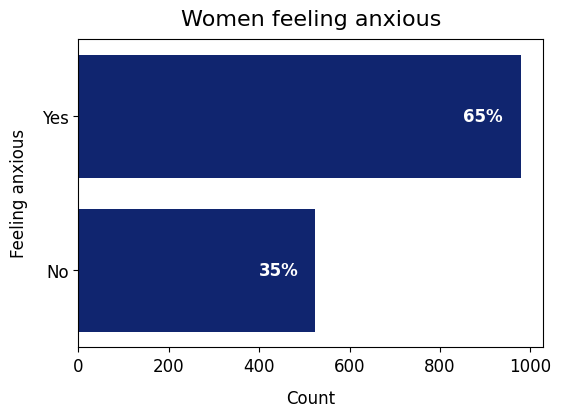

In [24]:
# Count plot of target variable 'feeling_anxious'

plt.figure(figsize=(6,4))
sns.countplot(y='feeling_anxious', data=df)
plt.xlabel(xlabel='Count', fontsize=12, labelpad=10)
plt.ylabel(ylabel='Feeling anxious', fontsize=12, labelpad=10)
plt.text(x=850, y=0, s=str(int(np.round(val_yes))) + "%", fontsize=12, fontweight='bold', color='w', va='center')
plt.text(x=400, y=1, s=str(int(np.round(val_no))) + "%", fontsize=12, fontweight='bold', color='w', va='center')
plt.title(label='Women feeling anxious', fontsize=16, pad=10)
plt.tick_params(axis='both', labelsize=12);

**Documentation**

Target variable is slightly imbalanced

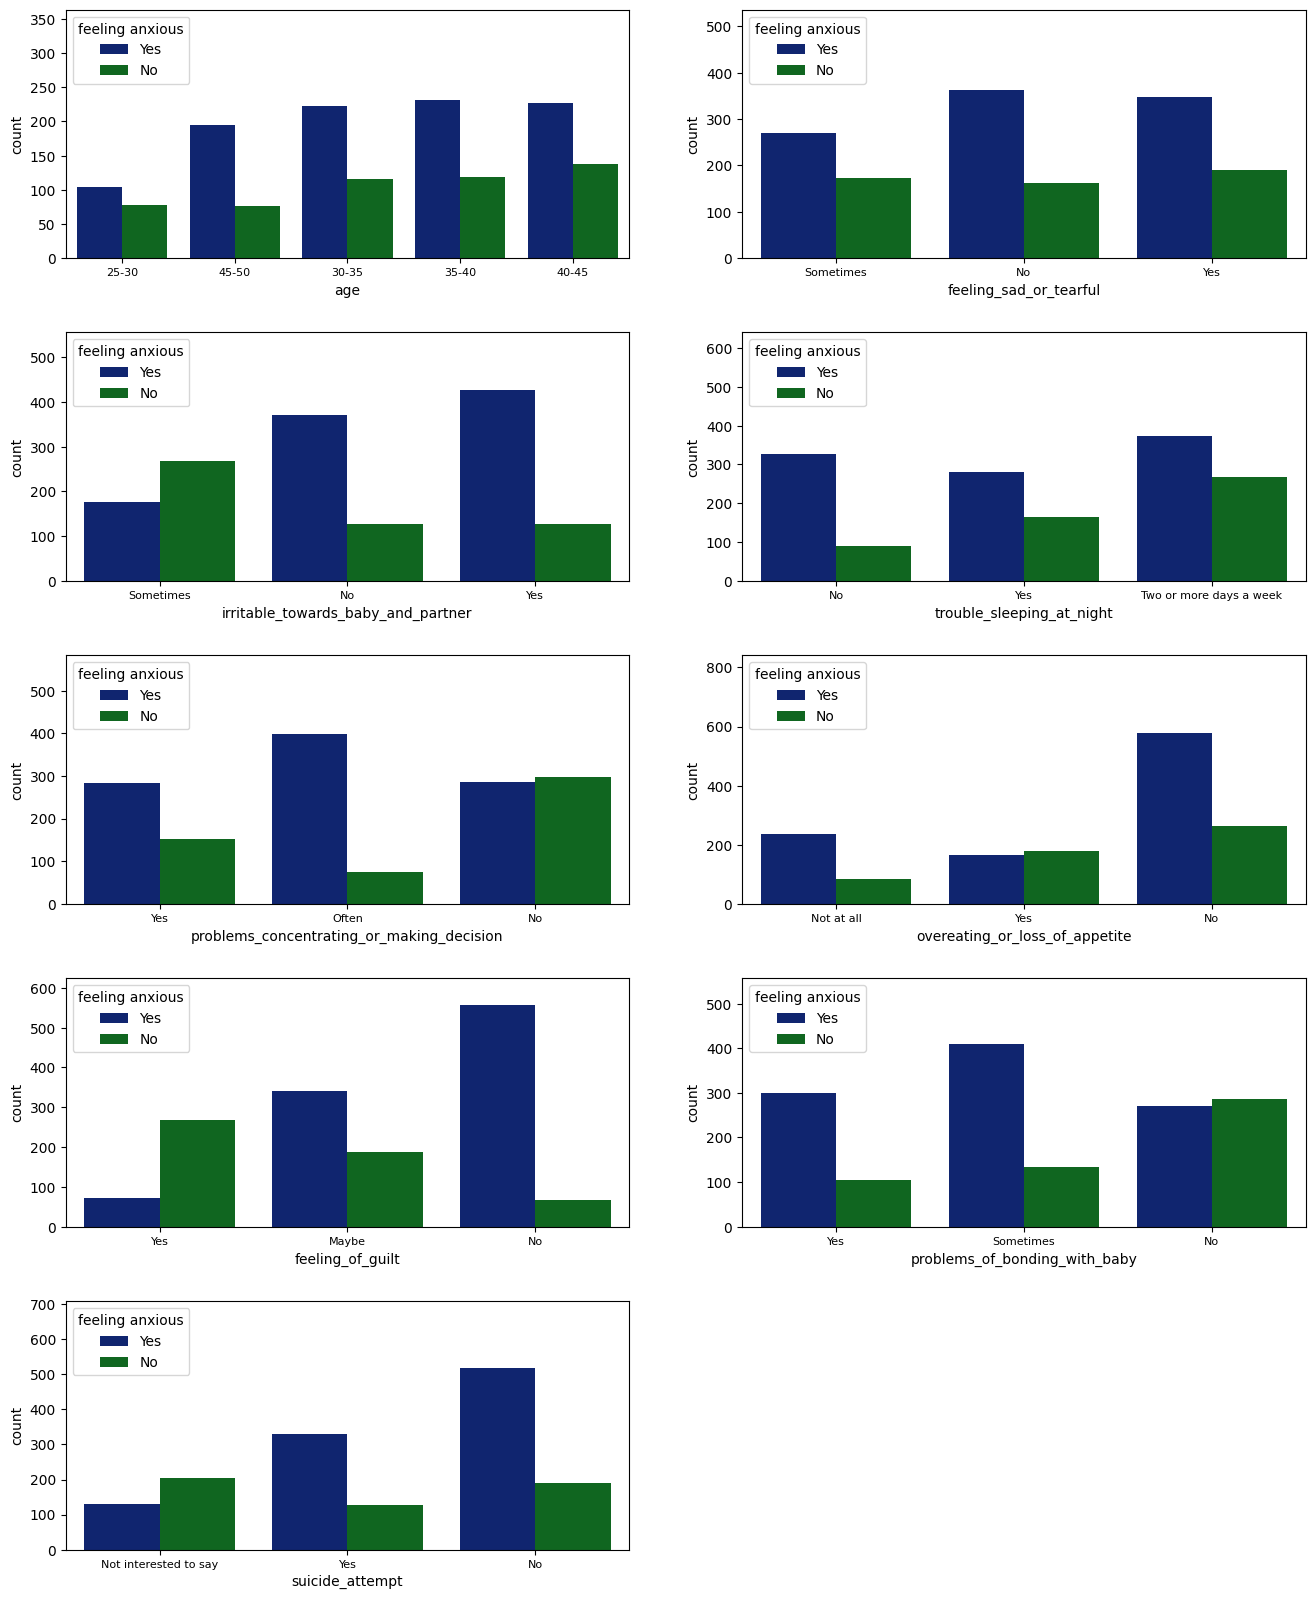

In [25]:
# Count plots of feature variables

# Features to plot
columns = [c for c in df.columns if c != 'feeling_anxious']

# Creating subplot axes
fig, axes = plt.subplots(5, 2, figsize=(16,20), sharey=False)
axes[4,1].set_axis_off()

# Iterating through axes and columns
for name, ax in zip(columns, axes.flatten()):
    sns.countplot(x=name, hue='feeling_anxious', data=df, order=df[name].value_counts(ascending=True).index, ax=ax)
    ax.tick_params(axis='x', labelsize=8)
    ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
    ax.set_ylim([0, max(df[name].value_counts())])
    ax.legend(title='feeling anxious', loc='upper left')
    plt.subplots_adjust(hspace=0.3);

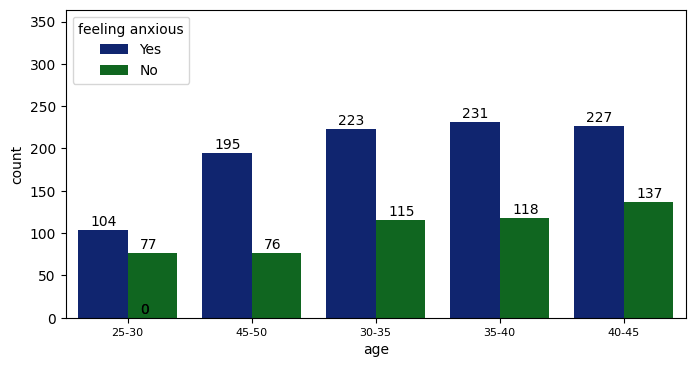

In [26]:
# Count plot of feature variable 'age' with annotation

# Feature to plot
name = 'age'

# Creating subplot axes
fig, ax = plt.subplots(1, 1, figsize=(8,4), sharey=False)
# axes[2,1].set_axis_off()

sns.countplot(x=name, hue='feeling_anxious', data=df, order=df[name].value_counts(ascending=True).index, ax=ax)
ax.tick_params(axis='x', labelsize=8)
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.subplots_adjust(hspace=0.3)
ax.set_ylim([0, max(df[name].value_counts())])
ax.legend(title='feeling anxious', loc='upper left')

for p in ax.patches:
    txt = str(int(np.round(p.get_height())))
    x = p.get_x()+0.1
    y = p.get_height()+5
    ax.text(x, y, txt);

**Documentation**

From the count plot one could deduce the correlation with 'feeling anxious' is:
* negative with 'feeling of guilt'
* positive with 'problems of bonding with baby'

All other features seem not to show a correlation

### 5.3.2. Feature correlation: Theil's U (Uncertainty Coefficient)

Theil's U, also known as the Uncertainty Coefficient, calculates statistic for categorical-categorical association. Formaly marked as U(x|y), this coefficient provides a value in the range of [0,1], where 0 means y provides no information about x, and 1 means y provides full information about x.

How to read the Theil's U heatmap:
* Knowing the value of feature on the y-axis
* Provides information regarding feature on the x-axis

In [27]:
# Moving target variable to last position in df
df_corr = df.copy()
df_corr['feeling_anxious'] = df_corr.pop('feeling_anxious')
df_corr.head()

,age,feeling_sad_or_tearful,irritable_towards_baby_and_partner,trouble_sleeping_at_night,problems_concentrating_or_making_decision,overeating_or_loss_of_appetite,feeling_of_guilt,problems_of_bonding_with_baby,suicide_attempt,feeling_anxious
0,35-40,Yes,Yes,Two or more days a week,Yes,Yes,No,Yes,Yes,Yes
1,40-45,Yes,No,No,Yes,Yes,Yes,Yes,No,No
2,35-40,Yes,No,Yes,Yes,Yes,No,Sometimes,No,Yes
3,35-40,Yes,Yes,Yes,Yes,No,Maybe,No,No,Yes
4,40-45,Yes,No,Two or more days a week,Yes,No,No,Yes,No,Yes


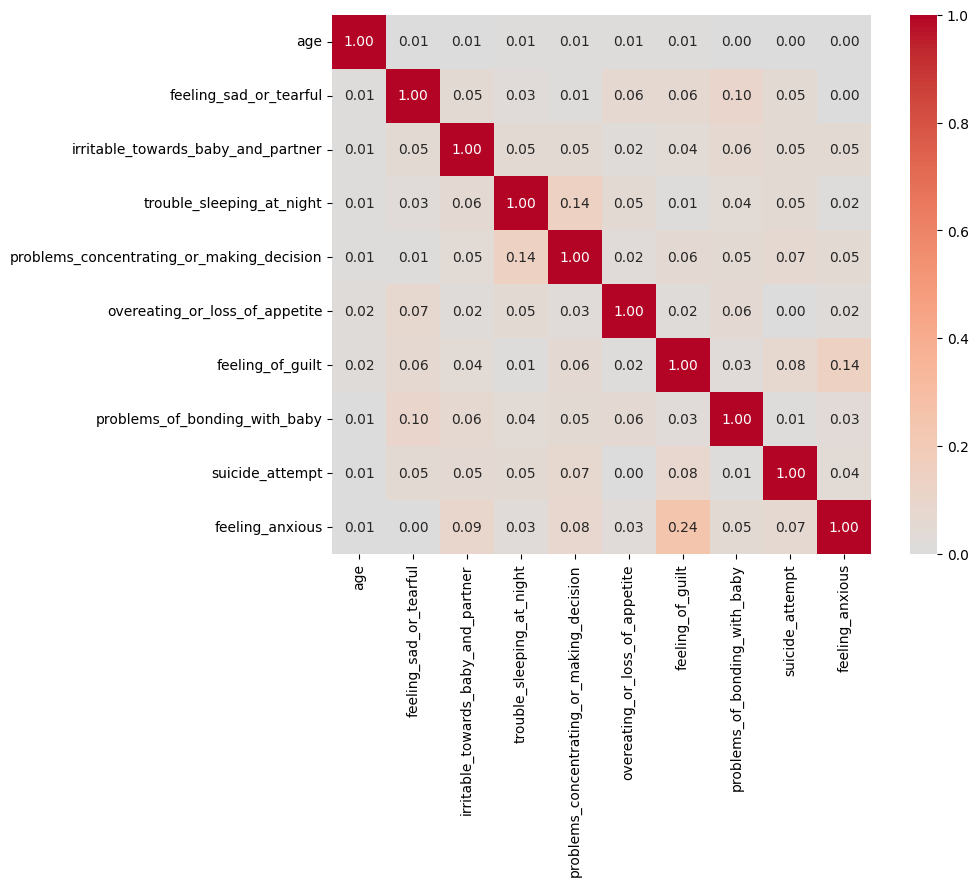

In [28]:
# Generating Theil’s U pairwise association plot
fig, ax = plt.subplots(figsize = (10, 7))

# Estimate and generate Theil's U association plot
theils_u = associations(df_corr, nom_nom_assoc='theil', vmin=0, vmax=1, cmap="coolwarm", fmt='.2f', ax=ax)

In [29]:
theils_u["corr"]

,age,feeling_sad_or_tearful,irritable_towards_baby_and_partner,trouble_sleeping_at_night,problems_concentrating_or_making_decision,overeating_or_loss_of_appetite,feeling_of_guilt,problems_of_bonding_with_baby,suicide_attempt,feeling_anxious
age,1.000000,0.006194,0.007465,0.008667,0.010085,0.012170,0.011192,0.004966,0.004975,0.002482
feeling_sad_or_tearful,0.008947,1.000000,0.048644,0.030428,0.010252,0.064382,0.064915,0.098857,0.047164,0.002257
irritable_towards_baby_and_partner,0.010580,0.047732,1.000000,0.053918,0.047381,0.018215,0.042472,0.062792,0.051746,0.053486
trouble_sleeping_at_night,0.012697,0.030860,0.055729,1.000000,0.144037,0.047548,0.014857,0.041735,0.051883,0.015357
problems_concentrating_or_making_decision,0.014135,0.009948,0.046855,0.137812,1.000000,0.024496,0.055423,0.049094,0.069266,0.047892
overeating_or_loss_of_appetite,0.019425,0.071144,0.020512,0.051807,0.027896,1.000000,0.017151,0.061662,0.002057,0.019569
feeling_of_guilt,0.016095,0.064630,0.043094,0.014585,0.056865,0.015452,1.000000,0.030324,0.077758,0.143909
problems_of_bonding_with_baby,0.007214,0.099432,0.064363,0.041390,0.050888,0.056125,0.030635,1.000000,0.014150,0.032326
suicide_attempt,0.007487,0.049133,0.054936,0.053293,0.074362,0.001939,0.081362,0.014656,1.000000,0.040315
feeling_anxious,0.006077,0.003825,0.092379,0.025662,0.083646,0.030013,0.244971,0.054469,0.065588,1.000000


**Documentation**

* 'Feeling of guilt' shows the strongest correlation (~25%) to the target variable `feeling_anxious`, i.e. knowing the value of 'feeling of guilt' provides ~25% of the information regarding the target variable

---

# 6. Modelling

## 6.1. Functions

### 6.1.1. Summary report

In [30]:
def summary_report_tree(model, X_test, y_test):
    """
    * Summary Report for Tree-based Models *

    Function to generate predictions and probabilities on input data,
    output model performance indicators and
    plot confusion matrix, precision-recall and ROC curve
    """
    # Make prediction on input data
    y_pred = model.predict(X_test)

    # Generate prediction probabilities for input data
    y_test_prob = model.predict_proba(X_test)[:,1]

    # Model performance
    accuracy_ = accuracy_score(y_test, y_pred)
    precision_ = precision_score(y_test, y_pred)
    recall_ = recall_score(y_test, y_pred)
    f1_ = f1_score(y_test, y_pred)
    roc_auc_ = roc_auc_score(y_test, y_pred)

    print(f'\033[1mSummary Report\033[0m')
    print(f'\033[1mAccuracy:  {accuracy_:.2f}\033[0m [TP / N] Proportion of predicted labels that match true labels')
    print(f'\033[1mPrecision: {precision_:.2f}\033[0m [TP / (TP + FP)] Ability of the classifier not to label as positive a sample that is negative')
    print(f'\033[1mRecall:    {recall_:.2f}\033[0m [TP / (TP + FN)] Ability of the classifier to find all positive samples')
    print(f'\033[1mF1-score:  {f1_:.2f}\033[0m [F1 = 2 * (precision * recall) / (precision + recall)] Harmonic mean of the precision and recall')
    print(f'\033[1mROC AUC:   {roc_auc_:.2f}\033[0m')
    print(113*'-')
    print('TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples')
    print(113*'-', '\n')

    # Confusion Matrix
    mat = confusion_matrix(y_test, y_pred)

    # Precision/Recall
    precision, recall, _ = precision_recall_curve(y_test, y_test_prob)

    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_test, y_test_prob)
    roc_auc = auc(fpr, tpr)

    # Plot
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
    fig.subplots_adjust(left=0.02, right=0.98, wspace=0.2)

    # Confusion Matrix
    group_names = ['TN','FP','FN','TP']
    group_counts = ["{0:0.0f}".format(value) for value in mat.flatten()]
    labels = [f"{v1}\n\n{v2}" for v1, v2 in zip(group_names,group_counts)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(mat, annot=labels, cmap=plt.cm.Blues, fmt="", ax=ax[0])
    ax[0].set_title('Confusion Matrix')
    ax[0].set_xlabel('Predicted label')
    ax[0].set_ylabel('True label')

    # Precision/Recall
    step_kwargs = {'step': 'post'}
    ax[1].step(recall, precision, color='b', alpha=0.2, where='post')
    ax[1].fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)
    ax[1].set_ylim([0.0, 1.0])
    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].set_title('2-class Precision-Recall curve')

    # ROC
    ax[2].plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
    ax[2].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax[2].set_xlim([0.0, 1.0])
    ax[2].set_ylim([0.0, 1.0])
    ax[2].set_xlabel('False Positive Rate (1-specificity)')
    ax[2].set_ylabel('True Positive Rate (sensitivity)')
    ax[2].set_title('Receiver Operating Characteristic')
    ax[2].legend(loc='lower right')

    plt.show()

    return accuracy_, precision_, recall_, f1_, roc_auc_

In [31]:
def summary_report_nn(model, X_test, y_test):
    """
    * Summary Report for Neural Network-based Models *

    Function to generate predictions and probabilities on input data,
    output model performance indicators and
    plot confusion matrix, precision-recall and ROC curve
    """
    # Make prediction on input data
    y_pred = ((model.predict(X_test)>0.5)*1).flatten()

    # Generate prediction probabilities for input data
    y_test_prob = model.predict(X_test)

    # Model performance
    accuracy_ = accuracy_score(y_test, y_pred)
    precision_ = precision_score(y_test, y_pred)
    recall_ = recall_score(y_test, y_pred)
    f1_ = f1_score(y_test, y_pred)
    roc_auc_ = roc_auc_score(y_test, y_pred)

    print(f'\n\033[1mSummary Report\033[0m')
    print(f'\033[1mAccuracy:  {accuracy_:.2f}\033[0m [TP / N] Proportion of predicted labels that match true labels')
    print(f'\033[1mPrecision: {precision_:.2f}\033[0m [TP / (TP + FP)] Ability of the classifier not to label as positive a sample that is negative')
    print(f'\033[1mRecall:    {recall_:.2f}\033[0m [TP / (TP + FN)] Ability of the classifier to find all positive samples')
    print(f'\033[1mF1-score:  {f1_:.2f}\033[0m [F1 = 2 * (precision * recall) / (precision + recall)] Harmonic mean of the precision and recall')
    print(f'\033[1mROC AUC:   {roc_auc_:.2f}\033[0m')
    print(113*'-')
    print('TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples')
    print(113*'-', '\n')

    # Confusion Matrix
    mat = confusion_matrix(y_test, y_pred)

    # Precision/Recall
    precision, recall, _ = precision_recall_curve(y_test, y_test_prob)

    # Compute ROC curve and ROC area
    fpr, tpr, _ = roc_curve(y_test, y_test_prob)
    roc_auc = auc(fpr, tpr)

    # Plot
    fig, ax = plt.subplots(1, 3, figsize=(18, 6))
    fig.subplots_adjust(left=0.02, right=0.98, wspace=0.2)

    # Confusion Matrix
    group_names = ['TN','FP','FN','TP']
    group_counts = ["{0:0.0f}".format(value) for value in mat.flatten()]
    labels = [f"{v1}\n\n{v2}" for v1, v2 in zip(group_names,group_counts)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(mat, annot=labels, cmap=plt.cm.Blues, fmt="", ax=ax[0])
    ax[0].set_title('Confusion Matrix')
    ax[0].set_xlabel('Predicted label')
    ax[0].set_ylabel('True label')

    # Precision/Recall
    step_kwargs = {'step': 'post'}
    ax[1].step(recall, precision, color='b', alpha=0.2, where='post')
    ax[1].fill_between(recall, precision, alpha=0.2, color='b', **step_kwargs)
    ax[1].set_ylim([0.0, 1.0])
    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].set_title('2-class Precision-Recall curve')

    # ROC
    ax[2].plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
    ax[2].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    ax[2].set_xlim([0.0, 1.0])
    ax[2].set_ylim([0.0, 1.0])
    ax[2].set_xlabel('False Positive Rate (1-specificity)')
    ax[2].set_ylabel('True Positive Rate (sensitivity)')
    ax[2].set_title('Receiver Operating Characteristic')
    ax[2].legend(loc='lower right')

    plt.show()

    return accuracy_, precision_, recall_, f1_, roc_auc_

### 6.1.2. Feature importance

In [32]:
def plot_feature_importance(data, dist):
    """
    Function to plot feature importance
    """
    fig, ax = plt.subplots(1, 1, figsize=(6,8), sharey=False)

    sns.barplot(x='feature_importance', y='feature', data=data)
    ax.set_xlabel(xlabel='Feature importance', fontsize=12, labelpad=10)
    ax.set_ylabel(ylabel='Feature', fontsize=12, labelpad=10)
    ax.set_title(label='Feature importance', fontsize=16, pad=10)
    ax.tick_params(axis='both', labelsize=9)
    ax.set_xlim([0, max(data['feature_importance'])*1.2])

    for p in ax.patches:
        width = p.get_width()
        x = p.get_width() + dist
        y = p.get_y()+0.55 * p.get_height()
        plt.text(x, y, '{:1.2f}'.format(width), ha='center', va='center');

### 6.1.3. Learning curves

In [33]:
def learning_curve_lightgbm(history):
    """
    Function to plot learning curves
    """
    plt.figure(figsize=(6,4))
    plt.plot(history['training']['binary_logloss'], color="r", label="Training")
    plt.plot(history['valid_1']['binary_logloss'], color="b", label="Testing")
    plt.legend(loc="upper right")
    plt.xlabel("Number of iterations", fontsize=16)
    plt.ylabel("logloss", fontsize=16)
    plt.ylim([0, max(history['training']['binary_logloss'])+0.1])
    plt.title(f"Learning Curves: LightGBM", fontsize=16);

In [34]:
def learning_curve_xgboost(history):
    """
    Function to plot learning curves
    """
    plt.figure(figsize=(6,4))
    plt.plot(history['validation_0']['logloss'], color="r", label="Training")
    plt.plot(history['validation_1']['logloss'], color="b", label="Testing")
    plt.legend(loc="upper right")
    plt.xlabel("Number of iterations", fontsize=16)
    plt.ylabel("logloss", fontsize=16)
    plt.ylim([0, max(history['validation_0']['logloss'])+0.1])
    plt.title(f"Learning Curves: XGBoost", fontsize=16);

In [35]:
def learning_curve_catboost(history):
    """
    Function to plot learning curves
    """
    plt.figure(figsize=(6,4))
    plt.plot(history['validation_0']['Logloss'], color="r", label="Training")
    plt.plot(history['validation_1']['Logloss'], color="b", label="Testing")
    plt.legend(loc="upper right")
    plt.xlabel("Number of iterations", fontsize=16)
    plt.ylabel("logloss", fontsize=16)
    plt.ylim([0, max(history['validation_0']['Logloss'])+0.1])
    plt.title(f"Learning Curves: CatBoost", fontsize=16);

In [36]:
def learning_curve_nn(history):
    """
    Function to plot training and validation loss and accuracy
    """
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    ax[0].plot(history.history["loss"], color="r", label="Training Loss")
    ax[0].plot(history.history["val_loss"], color="b", label="Validation Loss")
    ax[0].legend(loc="upper right")
    ax[0].set_xlabel("Epoch", fontsize=14)
    ax[0].set_ylabel("Loss", fontsize=14)
    ax[0].set_ylim([0, max(history.history["loss"])+1])
    ax[0].set_title("Training and Validation Loss", fontsize=16)

    ax[1].plot(history.history["accuracy"], color="r", label="Training Loss")
    ax[1].plot(history.history["val_accuracy"], color="b", label="Validation Loss")
    ax[1].legend(loc="best")
    ax[1].set_xlabel("Epoch", fontsize=14)
    ax[1].set_ylabel("Accuracy", fontsize=14)
    ax[1].set_ylim([0, max(history.history["accuracy"])+0.05])
    ax[1].set_title("Training and Validation Accuracy", fontsize=16);

## 6.2. Data pre-processing

### 6.2.1. Data input

In [37]:
# Shuffle data
df = shuffle(df, random_state=42)

In [38]:
# Define features and target
target = 'feeling_anxious'

X = df.drop(columns=target, axis=1).copy()
y = df[target].copy()

In [39]:
X.head(3)

,age,feeling_sad_or_tearful,irritable_towards_baby_and_partner,trouble_sleeping_at_night,problems_concentrating_or_making_decision,overeating_or_loss_of_appetite,feeling_of_guilt,problems_of_bonding_with_baby,suicide_attempt
51,40-45,No,Yes,Two or more days a week,No,No,No,No,Yes
1465,30-35,Sometimes,No,No,Often,No,Maybe,Yes,No
184,35-40,Sometimes,Yes,Yes,No,Yes,Yes,No,Not interested to say


In [40]:
y[:5]

,feeling_anxious
51,Yes
1465,Yes
184,No
1000,Yes
746,Yes


### 6.2.2. Missing value imputation

In [41]:
# # Group dataset by age bracket and fill missing values with the value that appears most often using 'mode'
# columns = ['irritable_towards_baby_and_partner',
#            'problems_concentrating_or_making_decision',
#            'feeling_of_guilt']

# for name in columns:
#     X[name] = X.groupby(by='age')[name].apply(lambda x: x.fillna(x.mode()[0]))

In [42]:
# Group dataset by age bracket and fill missing values with the value that appears most often using 'mode'
columns = ['irritable_towards_baby_and_partner',
           'problems_concentrating_or_making_decision',
           'feeling_of_guilt']

for name in columns:
    # Use transform instead of apply to ensure index alignment
    X[name] = X.groupby(by='age')[name].transform(lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan))

#Import numpy
import numpy as np

In [43]:
# Check for missing values
X.isna().sum()

,0
age,0
feeling_sad_or_tearful,0
irritable_towards_baby_and_partner,0
trouble_sleeping_at_night,0
problems_concentrating_or_making_decision,0
overeating_or_loss_of_appetite,0
feeling_of_guilt,0
problems_of_bonding_with_baby,0
suicide_attempt,0


**Encoding**

Categorical variables are:
* Binary (*feeling_anxious*) &rarr; label encoding
* Ordinal (*age*) &rarr; ordinal encoding
* Nominal (all other variables) &rarr; dummy encoding

### 6.2.3. Ordinal encoding

In [44]:
# Create map for age group
age_group = {'25-30': 1,
             '30-35': 2,
             '35-40': 3,
             '40-45': 4,
             '45-50': 5}

In [45]:
# Map age group
X['age'] = X['age'].map(age_group)

In [46]:
X.sample(3)

,age,feeling_sad_or_tearful,irritable_towards_baby_and_partner,trouble_sleeping_at_night,problems_concentrating_or_making_decision,overeating_or_loss_of_appetite,feeling_of_guilt,problems_of_bonding_with_baby,suicide_attempt
1314,4,No,Yes,Two or more days a week,No,No,No,No,Yes
497,5,Sometimes,Yes,Yes,No,Not at all,No,Yes,Not interested to say
843,3,Yes,Sometimes,Yes,Yes,Yes,Maybe,Sometimes,Yes


### 6.2.4. Dummy encoding

In [47]:
X = pd.get_dummies(data = X, columns = X.columns[1:])
X.head()

,age,feeling_sad_or_tearful_No,feeling_sad_or_tearful_Sometimes,feeling_sad_or_tearful_Yes,irritable_towards_baby_and_partner_No,irritable_towards_baby_and_partner_Sometimes,irritable_towards_baby_and_partner_Yes,trouble_sleeping_at_night_No,trouble_sleeping_at_night_Two or more days a week,trouble_sleeping_at_night_Yes,...,overeating_or_loss_of_appetite_Yes,feeling_of_guilt_Maybe,feeling_of_guilt_No,feeling_of_guilt_Yes,problems_of_bonding_with_baby_No,problems_of_bonding_with_baby_Sometimes,problems_of_bonding_with_baby_Yes,suicide_attempt_No,suicide_attempt_Not interested to say,suicide_attempt_Yes
51,4,True,False,False,False,False,True,False,True,False,...,False,False,True,False,True,False,False,False,False,True
1465,2,False,True,False,True,False,False,True,False,False,...,False,True,False,False,False,False,True,True,False,False
184,3,False,True,False,False,False,True,False,False,True,...,True,False,False,True,True,False,False,False,True,False
1000,3,True,False,False,False,False,True,False,True,False,...,False,False,True,False,True,False,False,False,False,True
746,2,True,False,False,False,False,True,False,True,False,...,False,False,True,False,True,False,False,False,False,True


### 6.2.5. Split dataset

In [48]:
# Split dataset
test_size = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=test_size, stratify=y)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1202, 25), (1202,), (301, 25), (301,))

In [49]:
X_train[:2]

,age,feeling_sad_or_tearful_No,feeling_sad_or_tearful_Sometimes,feeling_sad_or_tearful_Yes,irritable_towards_baby_and_partner_No,irritable_towards_baby_and_partner_Sometimes,irritable_towards_baby_and_partner_Yes,trouble_sleeping_at_night_No,trouble_sleeping_at_night_Two or more days a week,trouble_sleeping_at_night_Yes,...,overeating_or_loss_of_appetite_Yes,feeling_of_guilt_Maybe,feeling_of_guilt_No,feeling_of_guilt_Yes,problems_of_bonding_with_baby_No,problems_of_bonding_with_baby_Sometimes,problems_of_bonding_with_baby_Yes,suicide_attempt_No,suicide_attempt_Not interested to say,suicide_attempt_Yes
133,4,False,False,True,False,False,True,True,False,False,...,False,False,False,True,False,True,False,False,False,True
35,2,False,True,False,False,True,False,False,False,True,...,False,True,False,False,False,False,True,False,True,False


In [50]:
y_train[:5]

,feeling_anxious
133,No
35,Yes
984,Yes
110,Yes
1465,Yes


In [51]:
y_test[:5]

,feeling_anxious
583,No
851,No
616,No
707,Yes
354,Yes


### 6.2.6. Label encoding

In [52]:
# Label encoding
le = LabelEncoder()

y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

print(y_train.shape, y_test.shape)
y_train

(1202,) (301,)


array([0, 1, 1, ..., 0, 0, 1])

**Feature Importance**

## 6.4. Neural network-based models

In [54]:
X_train.head()

,age,feeling_sad_or_tearful_No,feeling_sad_or_tearful_Sometimes,feeling_sad_or_tearful_Yes,irritable_towards_baby_and_partner_No,irritable_towards_baby_and_partner_Sometimes,irritable_towards_baby_and_partner_Yes,trouble_sleeping_at_night_No,trouble_sleeping_at_night_Two or more days a week,trouble_sleeping_at_night_Yes,...,overeating_or_loss_of_appetite_Yes,feeling_of_guilt_Maybe,feeling_of_guilt_No,feeling_of_guilt_Yes,problems_of_bonding_with_baby_No,problems_of_bonding_with_baby_Sometimes,problems_of_bonding_with_baby_Yes,suicide_attempt_No,suicide_attempt_Not interested to say,suicide_attempt_Yes
133,4,False,False,True,False,False,True,True,False,False,...,False,False,False,True,False,True,False,False,False,True
35,2,False,True,False,False,True,False,False,False,True,...,False,True,False,False,False,False,True,False,True,False
984,3,False,True,False,True,False,False,True,False,False,...,False,True,False,False,False,False,True,True,False,False
110,3,False,False,True,True,False,False,False,False,True,...,False,False,True,False,False,True,False,True,False,False
1465,2,False,True,False,True,False,False,True,False,False,...,False,True,False,False,False,False,True,True,False,False


In [55]:
y_train

array([0, 1, 1, ..., 0, 0, 1])

### 6.4.1. Fully connected model

**Model architecture**

In [56]:
# Define model
clear_session()

n_cols = X_train.shape[1]

model = Sequential()
model.add(Dense(40, input_shape = (n_cols,), activation = 'relu'))
model.add(Dense(40, activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(1, activation = 'sigmoid'))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


**Compile model**

In [57]:
# Compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 40)                  │           1,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 40)                  │           1,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 40)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              41 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,721 (10.63 KB)

 Trainable params: 2,721 (10.63 KB)

 Non-trainable params: 0 (0.00 B)

**Fit model**

In [58]:
X_train = X_train.astype(np.float32)  # Ensure X_train is of type float32
y_train = y_train.astype(np.float32)

In [59]:
X_test = X_test.astype(np.float32)  # Ensure X_train is of type float32
y_test = y_test.astype(np.float32)

In [60]:
%%time

# Fit model
epochs = 50
batch_size = 10

history = model.fit(X_train, y_train, validation_split=0.2, epochs=epochs, batch_size=batch_size, verbose=0)

CPU times: user 17.4 s, sys: 718 ms, total: 18.1 s
Wall time: 31.7 s


In [61]:
# List data in history
print(history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])


**Learning curves**

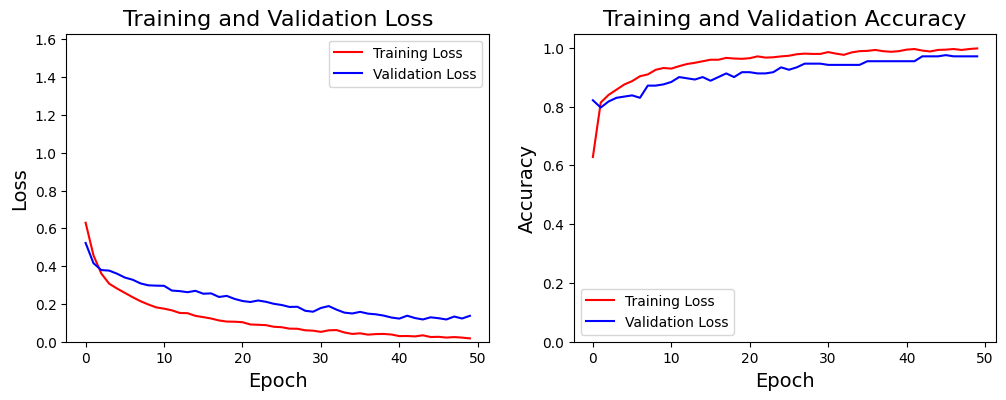

In [62]:
learning_curve_nn(history)

**Model evaluation**

In [63]:
# Evaluate model with test data
scores = model.evaluate(X_test, y_test, verbose = 0)
print(f'Test loss: {scores[0]:.4f}')
print(f'Test accuracy: {scores[1]:.4f}')

Test loss: 0.0940
Test accuracy: 0.9801


In [64]:
# Alternatively
for i, m in enumerate(model.metrics_names):
    print(f"{m}: {scores[i]:.4f}")

loss: 0.0940
compile_metrics: 0.9801


**Model prediction**

In [65]:
test_size = 5

# Use model.predict() to extract class probabilities
pred_prob = model.predict(X_test[:test_size])
pred_prob

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step


array([[5.1608668e-03],
       [2.1590453e-04],
       [4.9001079e-02],
       [9.9855602e-01],
       [9.9999911e-01]], dtype=float32)

In [66]:
# Set a probability threshold of 50% for classification, i.e. >0.5 is True
# Note! The '*1' converts the Boolean array into an array containing 0 or 1
pred = (pred_prob > 0.5)*1
pred.flatten()

array([0, 0, 0, 1, 1])

In [67]:
# Inverse label encoding
pred_ = le.inverse_transform(pred.flatten())
pred_

array(['No', 'No', 'No', 'Yes', 'Yes'], dtype=object)

In [68]:
# Prediction in a single line of code
pred_ = le.inverse_transform(((model.predict(X_test[:test_size])>0.5)*1).flatten())
pred_

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


array(['No', 'No', 'No', 'Yes', 'Yes'], dtype=object)

In [69]:
y_test[:test_size]

array([0., 0., 0., 1., 1.], dtype=float32)

In [70]:
# Retrieve true values from y_test
true_y = le.inverse_transform(y_test[:test_size].astype(int))
true_y

array(['No', 'No', 'No', 'Yes', 'Yes'], dtype=object)

In [71]:
# Compare prediction and true values
for i,j in zip(pred_, true_y):
    print("Predicted: {}, True: {}".format(i, j))

Predicted: No, True: No
Predicted: No, True: No
Predicted: No, True: No
Predicted: Yes, True: Yes
Predicted: Yes, True: Yes


In [72]:
# Compile results in df
pd.DataFrame(zip(pred_, true_y), columns=['feeling_anxious_Predicted', 'feeling_anxious_Actual'])

,feeling_anxious_Predicted,feeling_anxious_Actual
0,No,No
1,No,No
2,No,No
3,Yes,Yes
4,Yes,Yes


In [73]:
# Model prediction on entire test set
pred_ = le.inverse_transform(((model.predict(X_test)>0.5)*1).flatten())
true_y = le.inverse_transform(y_test.astype(int))

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


In [74]:
print(classification_report(true_y, pred_))

              precision    recall  f1-score   support

          No       0.96      0.98      0.97       105
         Yes       0.99      0.98      0.98       196

    accuracy                           0.98       301
   macro avg       0.98      0.98      0.98       301
weighted avg       0.98      0.98      0.98       301



### 6.4.2. Model evaluation

#### Evaluation of neural network-based models on training data


Neural Network

38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

Summary Report
Accuracy:  0.99 [TP / N] Proportion of predicted labels that match true labels
Precision: 1.00 [TP / (TP + FP)] Ability of the classifier not to label as positive a sample that is negative
Recall:    0.99 [TP / (TP + FN)] Ability of the classifier to find all positive samples
F1-score:  0.99 [F1 = 2 * (precision * recall) / (precision + recall)] Harmonic mean of the precision and recall
ROC AUC:   0.99
-----------------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples
----------------------------------------------------------------------------------------------------------------- 



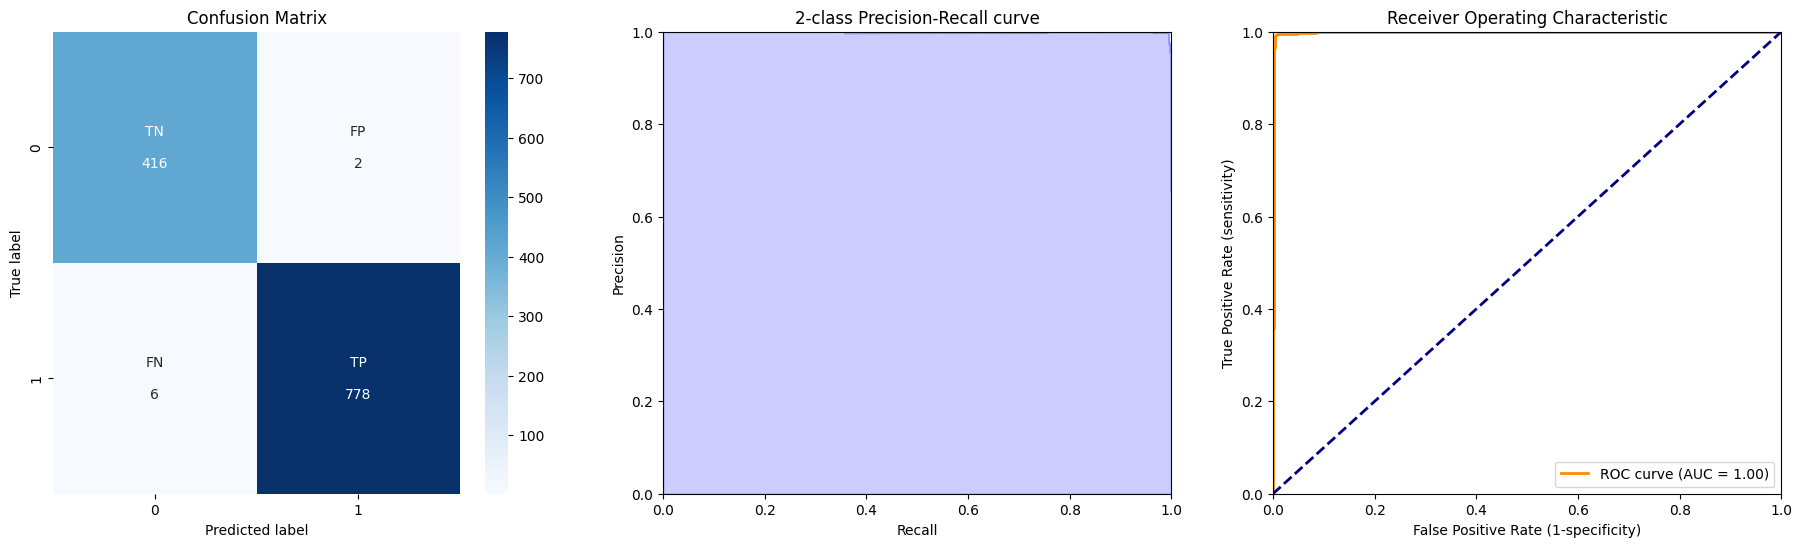

,Model,Set,Accuracy,Precision,Recall,F1-score,ROC_AUC
0,Neural Network,Train,0.993,0.997,0.992,0.995,0.994


In [75]:
## Print summary report including all plots and combine performance indicators of all models in a dataframe

# Create empty df with column headers
column_names = ['Model', 'Set', 'Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC_AUC']
results_train = pd.DataFrame(columns=column_names)

# Model names
models = ['Neural Network']

# Iterate through models
for i, m in enumerate([model]):
    print(f'\n\033[1m{Fore.BLUE}{models[i]}{Style.RESET_ALL}\033[0m\n')

    # Summary report
    accuracy_, precision_, recall_, f1_, roc_auc_ = summary_report_nn(m, X_train, y_train)

    # Round values
    list = [accuracy_, precision_, recall_, f1_, roc_auc_]
    accuracy_, precision_, recall_, f1_, roc_auc_ = [round(x, 3) for x in list]

    # Add results to df
    results_train.loc[i] = {'Model': models[i], 'Set': 'Train', 'Accuracy': accuracy_, 'Precision': precision_,
                            'Recall': recall_, 'F1-score': f1_, 'ROC_AUC': roc_auc_}

# Print dataframe with performance indicators for all models
print('\n')
results_train.sort_values(by='Model')

#### Evaluation of neural network-based models on testing data


Neural Network

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

Summary Report
Accuracy:  0.98 [TP / N] Proportion of predicted labels that match true labels
Precision: 0.99 [TP / (TP + FP)] Ability of the classifier not to label as positive a sample that is negative
Recall:    0.98 [TP / (TP + FN)] Ability of the classifier to find all positive samples
F1-score:  0.98 [F1 = 2 * (precision * recall) / (precision + recall)] Harmonic mean of the precision and recall
ROC AUC:   0.98
-----------------------------------------------------------------------------------------------------------------
TP: True Positives, FP: False Positives, TN: True Negatives, FN: False Negatives, N: Number of samples
----------------------------------------------------------------------------------------------------------------- 



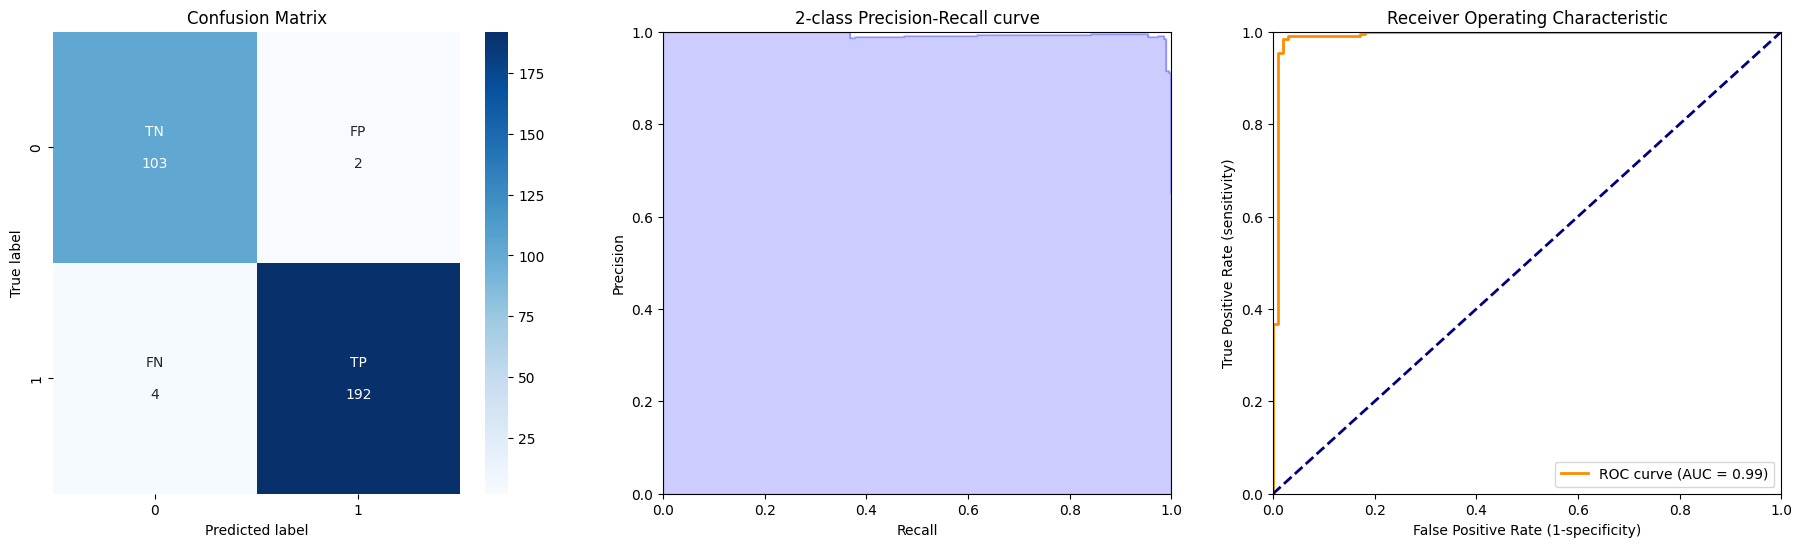

,Model,Set,Accuracy,Precision,Recall,F1-score,ROC_AUC
0,Neural Network,Train,0.993,0.997,0.992,0.995,0.994
1,Neural Network,Test,0.980,0.990,0.980,0.985,0.980


In [76]:
## Print summary report including all plots, combine performance indicators of all models and append to dataframe

results = results_train.copy()

# Model names
models = ['Neural Network']

# Iterate through models
for i, m in enumerate([model]):
    print(f'\n\033[1m{Fore.BLUE}{models[i]}{Style.RESET_ALL}\033[0m\n')

    # Summary report
    accuracy_, precision_, recall_, f1_, roc_auc_ = summary_report_nn(m, X_test, y_test)

    # Round values
    list = [accuracy_, precision_, recall_, f1_, roc_auc_]
    accuracy_, precision_, recall_, f1_, roc_auc_ = [round(x, 3) for x in list]

    # Add results to df
    results.loc[i+len(results_train)] = {'Model': models[i], 'Set': 'Test', 'Accuracy': accuracy_, 'Precision': precision_,
                                         'Recall': recall_, 'F1-score': f1_, 'ROC_AUC': roc_auc_}

# Copy results
results_nn_models = results.copy()

# Print dataframe with performance indicators for all models
print('\n')
results.sort_values(by=['Model', 'Set'], ascending = [True, False])

# Saving the model

In [78]:
model.save("postpartum.h5")

In [79]:
from tensorflow.keras.models import load_model

model = load_model("postpartum.h5")

In [84]:
import pandas as pd

# Create a dictionary with the data
data = {
    "age": [35, 43, 58, 66],
    "feeling_sad_or_tearful": ["Sometimes", "No", "Sometimes", "Yes"],
    "irritable_towards_baby_and_partner": ["Sometimes", "No", "Sometimes", "Yes"],
    "trouble_sleeping_at_night": ["Two or more days a week", "No", "Yes", "Yes"],
    "overeating_or_loss_of_appetite": ["Yes", "No", "No", "Yes"],
    "feeling_of_guilt": ["Maybe", "No", "No", "Yes"],
    "problems_of_bonding_with_baby": ["Sometimes", "No", "Sometimes", "Yes"],
    "suicide_attempt": ["No", "Not interested to say", "Yes", "Yes"]
}

# Create the DataFrame
df = pd.DataFrame(data)

# Print the DataFrame
df.head()

,age,feeling_sad_or_tearful,irritable_towards_baby_and_partner,trouble_sleeping_at_night,overeating_or_loss_of_appetite,feeling_of_guilt,problems_of_bonding_with_baby,suicide_attempt
0,35,Sometimes,Sometimes,Two or more days a week,Yes,Maybe,Sometimes,No
1,43,No,No,No,No,No,No,Not interested to say
2,58,Sometimes,Sometimes,Yes,No,No,Sometimes,Yes
3,66,Yes,Yes,Yes,Yes,Yes,Yes,Yes


In [85]:
df['age'] = df['age'].map(age_group)

In [86]:
df = pd.get_dummies(data = df, columns = df.columns[1:])
df.head()

,age,feeling_sad_or_tearful_No,feeling_sad_or_tearful_Sometimes,feeling_sad_or_tearful_Yes,irritable_towards_baby_and_partner_No,irritable_towards_baby_and_partner_Sometimes,irritable_towards_baby_and_partner_Yes,trouble_sleeping_at_night_No,trouble_sleeping_at_night_Two or more days a week,trouble_sleeping_at_night_Yes,...,overeating_or_loss_of_appetite_Yes,feeling_of_guilt_Maybe,feeling_of_guilt_No,feeling_of_guilt_Yes,problems_of_bonding_with_baby_No,problems_of_bonding_with_baby_Sometimes,problems_of_bonding_with_baby_Yes,suicide_attempt_No,suicide_attempt_Not interested to say,suicide_attempt_Yes
0,NaN,False,True,False,False,True,False,False,True,False,...,True,True,False,False,False,True,False,True,False,False
1,NaN,True,False,False,True,False,False,True,False,False,...,False,False,True,False,True,False,False,False,True,False
2,NaN,False,True,False,False,True,False,False,False,True,...,False,False,True,False,False,True,False,False,False,True
3,NaN,False,False,True,False,False,True,False,False,True,...,True,False,False,True,False,False,True,False,False,True


In [ ]:
model.predict

In [ ]:
!python -m tf2onnx.convert --h5 test02.h5 --output custom_model.onnx

ModuleNotFoundError: No module named 'gradio'